# use Python 3 (ipykernel)

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

In [8]:
#Parameters
K_bar = 1 #Number of tracks generated by the generator
num_sequential_bars = 1 #For discriminator
num_tracks = 1 #For discriminator
batch_size = 64
skip_connections = True
random_vector_size=16
discriminator_extra_steps = 3

In [27]:
# load trained autoencoder
from tensorflow.keras.models import load_model
trained_autoencoder = load_model('NEWpiano_encoder-loss0.03.hdf5', custom_objects={'LeakyReLU': LeakyReLU})
trained_autoencoder.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 84, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 96, 7, 16)    208         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 96, 7, 16)    64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 96, 1, 16)    1808        batch_normalization_9[0][0]      
________________________________________________________________________________________

In [46]:
# GAN generator structure

# pretrained encoder
pretrained_encoder_input = trained_autoencoder.input
pretrained_encoder_output = trained_autoencoder.get_layer(index=11).output
skip1_output = trained_autoencoder.get_layer(index=8).output
skip2_output = trained_autoencoder.get_layer(index=6).output
pretrained_encoder = tf.keras.Model(pretrained_encoder_input,pretrained_encoder_output,name='pretrained_encoder')
#Thomas: try to freeze the encoder training first, to stabilize training 
pretrained_encoder.trainable = False #TRUE NOW

# generator
generator_input = tf.keras.Input((1,1,16+random_vector_size), name='gen_input')
skip1_input = tf.keras.Input((4,1,8), name='skip1_input')
skip2_input = tf.keras.Input((16,1,16), name='skip2_input')
x = tf.keras.layers.Conv2DTranspose(1024,(2,1),(2,1),activation="relu")(generator_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(256,(2,1),(2,1),activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.concatenate([x,skip1_input])
x = tf.keras.layers.Conv2DTranspose(256,(2,1),(2,1),activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(256,(2,1),(2,1),activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.concatenate([x,skip2_input])
x = tf.keras.layers.Conv2DTranspose(128,(2,1),(2,1),activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(128,(3,1),(3,1),activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(64,(1,7),(1,7),activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(K_bar,(1,12),(1,12),activation="sigmoid")(x)
generator_output = tf.keras.layers.BatchNormalization()(x)
generator = tf.keras.Model([generator_input,skip1_input,skip2_input],generator_output,name='generator')


#random vector
random_vector_input = tf.keras.Input((random_vector_size))

#concatenate
random_and_latent = tf.keras.layers.concatenate([pretrained_encoder.output, random_vector_input],axis=-1)
random_and_latent = tf.keras.layers.Reshape((1,1,16+random_vector_size))(random_and_latent)

#generator
gan = generator([random_and_latent,skip1_output,skip2_output])

gan_generator = tf.keras.Model([pretrained_encoder_input, random_vector_input],gan,name='gan_generator')

In [29]:
# discriminator: 1: Fake, 0: Real
discriminator_paired_input1 = tf.keras.Input((num_sequential_bars,96,84,num_tracks))
discriminator_paired_input2 = tf.keras.Input((num_sequential_bars,96,84,num_tracks))
x = tf.keras.layers.concatenate([discriminator_paired_input1,discriminator_paired_input2])
x = tf.keras.layers.Conv3D(128,(1,1,1),(1,1,1),activation=LeakyReLU())(x)
x = tf.keras.layers.Conv3D(128,(1,1,1),(1,1,1),activation=LeakyReLU())(x)
x = tf.keras.layers.Conv3D(128,(1,1,12),(1,1,12),activation=LeakyReLU())(x)
x = tf.keras.layers.Conv3D(128,(1,1,7),(1,1,7),activation=LeakyReLU())(x)
x = tf.keras.layers.Conv3D(128,(1,2,1),(1,2,1),activation=LeakyReLU())(x)
x = tf.keras.layers.Conv3D(128,(1,2,1),(1,2,1),activation=LeakyReLU())(x)
x = tf.keras.layers.Conv3D(256,(1,4,1),(1,4,1),activation=LeakyReLU())(x)
x = tf.keras.layers.Conv3D(512,(1,3,1),(1,2,1),activation=LeakyReLU())(x)
x = tf.keras.layers.Flatten()(x)
#Thomas: CHange this to linear (from sigmoid)
discriminator_output = tf.keras.layers.Dense(1, activation='linear')(x)
discriminator_paired = tf.keras.Model([discriminator_paired_input1,discriminator_paired_input2],discriminator_output)

In [47]:
gan_generator.summary()

Model: "gan_generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 84, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 96, 7, 16)    208         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 96, 7, 16)    64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 96, 1, 16)    1808        batch_normalization_9[0][0]      
______________________________________________________________________________________

In [48]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gen_input (InputLayer)          [(None, 1, 1, 32)]   0                                            
__________________________________________________________________________________________________
conv2d_transpose_58 (Conv2DTran (None, 2, 1, 1024)   66560       gen_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, 2, 1, 1024)   4096        conv2d_transpose_58[0][0]        
__________________________________________________________________________________________________
conv2d_transpose_59 (Conv2DTran (None, 4, 1, 256)    524544      batch_normalization_58[0][0]     
__________________________________________________________________________________________

In [7]:
discriminator_paired.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 96, 84, 1 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1, 96, 84, 1 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1, 96, 84, 2) 0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 1, 96, 84, 12 384         concatenate_1[0][0]          

In [8]:
#piano to orchestra
#Thomas: WGAN-GP https://keras.io/examples/generative/wgan_gp/
class GAN_p2o(tf.keras.Model):
    def __init__(self, discriminator, generator,discriminator_extra_steps,gp_weight=10):
        super(GAN_p2o, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
        self.generator_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.discriminator_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        
    @property
    def metrics(self):
        return [self.generator_loss_tracker, self.discriminator_loss_tracker]
    
    def compile(self, discriminator_optimizer, generator_optimizer, d_loss_fn,g_loss_fn):
        super(GAN_p2o, self).compile()
        self.d_optimizer = discriminator_optimizer
        self.g_optimizer = generator_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        
    def gradient_penalty(self, batch_size, real_piano, real_orchestra,fake_orchestra):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1,1,1,1], 0.0, 1.0)
        diff = fake_orchestra - real_orchestra
        interpolated = real_orchestra + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator([real_piano,interpolated], training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
        
    def train_step(self, data):
        # input Assumption (not verified yet)
        # piano_x: Shape(96,84,1), a bar of paried piano score
        # (Removed) random_vector: Shape(16), a random vector sampled from Normal(0,1)
        # orchestra_y: Shape(96,84,1), a bar of paired orchestra score
        piano_x, orchestra_y = data
        batch_size = tf.shape(piano_x)[0]
        #train discriminator
        for i in range(self.d_steps):
            random_vector = tf.random.normal(shape=(batch_size, random_vector_size))
            with tf.GradientTape() as tape:
                fake_orchestra = self.generator([piano_x,random_vector])
                fake_orchestra = tf.reshape(fake_orchestra, (-1,1,96,84,1))
                real_orchestra = tf.reshape(orchestra_y, (-1,1,96,84,1))
                piano_input = tf.reshape(piano_x, (-1,1,96,84,1)) 
                fake_prediction = self.discriminator([piano_input,fake_orchestra])
                real_prediction = self.discriminator([piano_input,real_orchestra])
                d_cost = self.d_loss_fn(real_prediction,fake_prediction)
                gp = self.gradient_penalty(batch_size,piano_input,real_orchestra,fake_orchestra)
                d_loss = d_cost + gp * self.gp_weight
            d_gradient= tape.gradient(d_loss,self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_weights))
            
        #train generator
        random_vector = tf.random.normal(shape=(batch_size, random_vector_size))
        with tf.GradientTape() as tape:
            fake_orchestra = self.generator([piano_x,random_vector])
            fake_orchestra = tf.reshape(fake_orchestra, (-1,1,96,84,1))
            piano_input = tf.reshape(piano_x, (-1,1,96,84,1)) 
            discriminator_pred = self.discriminator([piano_input,fake_orchestra])
            g_loss = self.g_loss_fn(discriminator_pred)
        #calculate generator gradient
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_weights)
        #update generator weight        
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_weights))
        
        #Loss
        self.generator_loss_tracker.update_state(g_loss)
        self.discriminator_loss_tracker.update_state(d_loss)
        return{"generator_loss": self.generator_loss_tracker.result(),
               "discriminator_loss": self.discriminator_loss_tracker.result()}
    

In [9]:
test = GAN_p2o(discriminator_paired, gan_generator,discriminator_extra_steps)

In [10]:
def discriminator_loss(real_img, fake_img):
    #basically real = -1, fake = 1 here, using lienar function with reduce_mean to avoid optimizing to a certain value
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


test.compile(tf.keras.optimizers.Adam(learning_rate=0.0003), #discriminator
             tf.keras.optimizers.Adam(learning_rate=0.0003), #generator
             discriminator_loss, #ORiginal : CrossEntropy
             generator_loss
            )

# TRAINING STAGE
1. Train two autoencoders on orchestra and piano samples respectively.
2. Pre-train Generators with pretrain_discriminator, on orchestra and piano repsectively (pix2pix approach)
3. Train on unpaired with Cycle-GAN approach #we update G once every five updates of D and apply batch normalization only to G

In [5]:
import pickle 
with open("paired.pickle","rb") as f:
    paired_data = pickle.load(f)
print(len(paired_data))

124


In [6]:
orchestra=[]
piano=[]
for piece in paired_data:
    for segment in piece['o']:
        for bar in segment:
            if bar is not None:
                orchestra.append(bar)
    for segment in piece['p']:
        for bar in segment:
            if bar is not None:
                piano.append(bar)
orchestra=np.array(orchestra).astype('float32')
piano=np.array(piano).astype('float32')
assert(orchestra.shape == piano.shape)

In [22]:
assert(piano.shape == orchestra.shape)
dataset = tf.data.Dataset.from_tensor_slices((piano, orchestra))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [33]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 0:
            test.generator.save(f"pretrain1_gen{epoch}")
            test.discriminator.save(f"pretrain1_dis{epoch}")

In [35]:
history = test.fit(dataset, epochs=2,verbose=2,callbacks=[CustomCallback()])

Epoch 1/2
319/319 - 213s - generator_loss: -2.7950e+01 - discriminator_loss: -1.8208e+01
Epoch 2/2
319/319 - 219s - generator_loss: -2.6119e+01 - discriminator_loss: -1.8305e+01


INFO:tensorflow:Assets written to: pretrain1_gen1/assets


INFO:tensorflow:Assets written to: pretrain1_gen1/assets


INFO:tensorflow:Assets written to: pretrain1_dis1/assets


INFO:tensorflow:Assets written to: pretrain1_dis1/assets


In [ ]:
# DEBUG

In [ ]:
# test

In [4]:
#some visualization
from miditoolkit.pianoroll import parser as pr_parser
from miditoolkit.midi import parser as mid_parser
from miditoolkit.midi import containers as ct
def write_midi(notes,path='out.mid',tick_per_beat=24):
    out = mid_parser.MidiFile()
    out.ticks_per_beat = tick_per_beat
    out.instruments = [ct.Instrument(program=0,is_drum=False,name='post-processed piano')]
    for note in notes:
        assert(note.velocity)
        out.instruments[0].notes.append(ct.Note(start=note.start,end=note.end,pitch=note.pitch,velocity=90))
    out.dump(path)
def to_notes(piano_roll):
    pad_size=len(piano_roll)
    padded_pianoroll=piano_roll.T
    padded_pianoroll=np.vstack((np.zeros((24,pad_size)),padded_pianoroll,np.zeros((20,pad_size)))).T
    notes_from_pianoroll = pr_parser.pianoroll2notes(padded_pianoroll)
    return notes_from_pianoroll

# example = np.array(piano[100:108])
# example2 = np.array(orchestra[100:108])
# example=example.reshape((-1,84))
# example2 = example2.reshape((-1,84))
# write_midi(to_notes(example),path="paired_piano.mid")
# write_midi(to_notes(example2),path="paired_orchestra.mid")

In [ ]:
random_vector = tf.random.normal(shape=(128, random_vector_size))

In [ ]:
a=test.generator([piano[:128],random_vector])

In [ ]:
res = test.discriminator([tf.reshape(piano[:128], (-1,1,96,84,1)),
                    tf.reshape(a, (-1,1,96,84,1))])

In [ ]:
for row in a[0]:
    for cell in row:
        print(int(cell),end=' ')
    print()

In [ ]:
a[0]

In [23]:
#Case study
o_ex = orchestra[200:208]
p_ex = piano[200:208]
p_ex = p_ex.reshape((-1,96,84))
random_vector = tf.random.normal(shape=(len(p_ex), random_vector_size))
p2o = loaded_model.predict([p_ex,random_vector])
p2o_check_discriminator_output = p2o.reshape((-1,1,96,84,1))
pex_check_discriminator_output = p_ex.reshape((-1,1,96,84,1))
oex_check_discriminator_output = o_ex.reshape((-1,1,96,84,1))
check = test.discriminator.predict([pex_check_discriminator_output,p2o_check_discriminator_output])
print(check)
check2 = test.discriminator.predict([pex_check_discriminator_output,oex_check_discriminator_output])
print(check2)
print(p2o.shape)
o_ex = o_ex.reshape((-1,84))
p_ex = p_ex.reshape((-1,84))
p2o = p2o.reshape((-1,84))
p2o = (p2o>0.5)*1
write_midi(to_notes(o_ex),path="paired_piano.mid")
write_midi(to_notes(p_ex),path="paired_orchestra.mid")
write_midi(to_notes(p2o),path="paired_p2o.mid")

[[48.758144]
 [35.054867]
 [27.918   ]
 [47.79288 ]
 [49.371353]
 [42.92134 ]
 [41.624752]
 [36.90058 ]]
[[67.96299 ]
 [62.325516]
 [59.194748]
 [59.89305 ]
 [78.7828  ]
 [65.86717 ]
 [68.41563 ]
 [61.9779  ]]
(8, 96, 84, 1)
paired_piano.mid
paired_orchestra.mid
paired_p2o.mid


In [11]:
# check training results of o2p
import tensorflow as tf
trained_gen = tf.keras.models.load_model('pretrain2_o2p_gen90.h5', custom_objects={'LeakyReLU': LeakyReLU})
trained_dis = tf.keras.models.load_model('pretrain2_o2p_dis90.h5', custom_objects={'LeakyReLU': LeakyReLU})
trained_gen.summary()
trained_dis.summary()

Model: "gan_generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 84, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 96, 7, 16)    208         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 96, 7, 16)    64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 96, 1, 16)    1808        batch_normalization_9[0][0]      
______________________________________________________________________________________

In [54]:
#Case study
for i in range(16):
    o_ex = piano[300:308]
    p_ex = orchestra[300:308]
    p_ex = p_ex.reshape((-1,96,84))
    random_vector = np.zeros(shape=(len(p_ex), random_vector_size))
    random_vector[0][i] = 1
    p2o = trained_gen.predict([p_ex,random_vector])
    p2o_check_discriminator_output = p2o.reshape((-1,1,96,84,1))
    pex_check_discriminator_output = p_ex.reshape((-1,1,96,84,1))
    oex_check_discriminator_output = o_ex.reshape((-1,1,96,84,1))
    check = trained_dis.predict([pex_check_discriminator_output,p2o_check_discriminator_output])
    print(check)
    check2 = trained_dis.predict([pex_check_discriminator_output,oex_check_discriminator_output])
    print(check2)
    print(p2o.shape)
    o_ex = o_ex.reshape((-1,84))
    p_ex = p_ex.reshape((-1,84))
    p2o = p2o.reshape((-1,84))
    p2o = (p2o>0.5)*1
    write_midi(to_notes(p2o),path=f"paired_o2p_{i}.mid")

[[-163.80586]
 [-196.06877]
 [-227.19725]
 [-159.2756 ]
 [-190.45132]
 [-213.0126 ]
 [-131.37949]
 [-204.15167]]
[[-148.05322]
 [-179.98708]
 [-209.81982]
 [-151.40926]
 [-181.1845 ]
 [-210.33598]
 [-119.08073]
 [-185.11209]]
(8, 96, 84, 1)
paired_o2p_0.mid
[[-163.74603]
 [-196.06877]
 [-227.19725]
 [-159.2756 ]
 [-190.45132]
 [-213.0126 ]
 [-131.37949]
 [-204.15167]]
[[-148.05322]
 [-179.98708]
 [-209.81982]
 [-151.40926]
 [-181.1845 ]
 [-210.33598]
 [-119.08073]
 [-185.11209]]
(8, 96, 84, 1)
paired_o2p_1.mid
[[-163.69057]
 [-196.06877]
 [-227.19725]
 [-159.2756 ]
 [-190.45132]
 [-213.0126 ]
 [-131.37949]
 [-204.15167]]
[[-148.05322]
 [-179.98708]
 [-209.81982]
 [-151.40926]
 [-181.1845 ]
 [-210.33598]
 [-119.08073]
 [-185.11209]]
(8, 96, 84, 1)
paired_o2p_2.mid
[[-163.70187]
 [-196.06877]
 [-227.19725]
 [-159.2756 ]
 [-190.45132]
 [-213.0126 ]
 [-131.37949]
 [-204.15167]]
[[-148.05322]
 [-179.98708]
 [-209.81982]
 [-151.40926]
 [-181.1845 ]
 [-210.33598]
 [-119.08073]
 [-185.11209]]


In [12]:
#Case study
o_ex = orchestra[300:308]
p_ex = piano[300:308]
p_ex = p_ex.reshape((-1,96,84))
random_vector = tf.random.normal(shape=(len(p_ex), random_vector_size))
p2o = trained_gen.predict([p_ex,random_vector])
p2o_check_discriminator_output = p2o.reshape((-1,1,96,84,1))
pex_check_discriminator_output = p_ex.reshape((-1,1,96,84,1))
oex_check_discriminator_output = o_ex.reshape((-1,1,96,84,1))
check = trained_dis.predict([pex_check_discriminator_output,p2o_check_discriminator_output])
print(check)
check2 = trained_dis.predict([pex_check_discriminator_output,oex_check_discriminator_output])
print(check2)
print(p2o.shape)
o_ex = o_ex.reshape((-1,84))
p_ex = p_ex.reshape((-1,84))
p2o = p2o.reshape((-1,84))
p2o = (p2o>0.5)*1
write_midi(to_notes(p2o),path=f"paired_o2p_sample.mid")

[[-41.441525]
 [-46.31271 ]
 [-48.334732]
 [-49.571663]
 [-46.0318  ]
 [-66.91684 ]
 [-66.13374 ]
 [-64.79772 ]]
[[-40.534096]
 [-37.26453 ]
 [-41.845974]
 [-40.43189 ]
 [-40.56807 ]
 [-65.78998 ]
 [-67.076416]
 [-62.728607]]
(8, 96, 84, 1)


In [10]:
import pickle
with open("train_history_o2p.pickle","rb") as f:
    losses = pickle.load(f)
    
losses

{'generator_loss': [17.13387680053711,
  -41.89957809448242,
  3.934168577194214,
  23.50783348083496,
  24.656169891357422,
  20.239099502563477,
  13.699612617492676,
  17.90256118774414,
  16.671100616455078,
  19.425386428833008,
  8.569153785705566,
  3.4579386711120605,
  -2.49971342086792,
  -0.5727148056030273,
  -3.894751787185669,
  -6.869997978210449,
  -2.197458505630493,
  -2.874846935272217,
  -6.306809902191162,
  -7.884347438812256,
  -12.19917106628418,
  -16.15288543701172,
  -14.2255859375,
  -14.429638862609863,
  -15.355735778808594,
  -13.154736518859863,
  -8.6796875,
  -11.414508819580078,
  -12.76332950592041,
  -13.600305557250977,
  -15.117698669433594,
  -12.79772663116455,
  -19.91156768798828,
  -17.870363235473633,
  -18.438575744628906,
  -24.84276580810547,
  -22.19681167602539,
  -24.492786407470703,
  -19.560192108154297,
  -18.847644805908203,
  -23.765026092529297,
  -23.058881759643555,
  -22.76059913635254,
  -24.253276824951172,
  -26.8271484375,

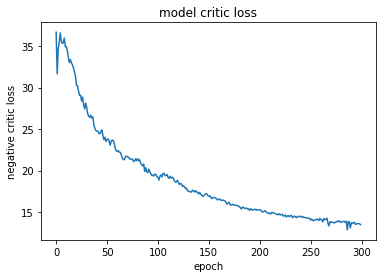

In [17]:
import matplotlib.pyplot as plt
loss = np.array(losses['discriminator_loss'])
loss = -loss
# plt.plot(losses['generator_loss'])
plt.plot(loss)
plt.title('model critic loss')
plt.ylabel('negative critic loss')
plt.xlabel('epoch')
plt.show()